## Import packages

In [1]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import time
from pylab import rcParams
import copy
from sklearn.cluster import KMeans
import math
import matplotlib

## Define fitness function for TSP problem

In [2]:
def routeFitness(route, dm):
    dist = 0
    for i in range(len(route)-1):
        dist += dm[route[i], route[i+1]]
    dist += dm[route[-1], route[0]]
    fitness = 1/dist
    
    return fitness

## Define a function to compute euclidean matrix between points

In [3]:
def dist_matrix(df):
    list_of_distances = [] # just to make it simple, probably there are 1k better ways to do this
    for point in df.itertuples():
        a = point[1]
        b = point[2]
        for point_s in df.itertuples():
            c = point_s[1]
            d = point_s[2]
            dist = math.sqrt(((c-a)**2) + ((d-b)**2))
            list_of_distances.append(dist)
    dist_matrix = np.array(list_of_distances) # convertion to array
    dist_matrix = np.reshape(dist_matrix, (len(df), len(df))) # reshaping
    # dist_matrix.shape # check
    return dist_matrix

## Define a function to initialize our population

In [4]:
def initPopulation(popSize, cities):
    population = []
    [population.append(random.sample(cities, len(cities))) for i in range(0, popSize)]
#     for i in range(0, popSize):
#         population.append(createRoute(cityList))
    return population

## Define a function to compute the error

In [5]:
def errPerc(exactValue, currValue, nRound = 2):
    errp = round((abs(exactValue - currValue) / exactValue)*100, nRound)
    return errp

## Define a function to plot our results

In [6]:
def plot(points, path: list, dist, name_tsp, save = False):
    x = []
    y = []
    for point in points.itertuples():
        x.append(point[1])
        y.append(point[2])
    
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co', markersize = 4, alpha = 0.8)

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]

        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r',
                  length_includes_head=True, linewidth = 0.3, alpha = 0.8)

    #plt.xlim(0, max(x) * 1.1)

    #plt.ylim(0, max(y) * 1.1)

    label_t = 'Best route for {}'.format(name_tsp)
    label_dist = 'distance: {}'.format(round(dist, 2))
    
    plt.annotate(label_dist, xy=(0.85, 0.98), xycoords='axes fraction')
    plt.title(label_t, loc='center')
    
    if save:
        plt.savefig('figs/best_{}.png'.format(name_tsp), dpi = 300)

## Define the main algorithm

In [7]:
def GenA(permutation, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot = False, verbose = False):
    start = time.time()
    pop = initPopulation(popSize, permutation)
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)
    traceBest = 1/rankedRoutes[0][1]
    
    
    if plot:
        progress = []
        progress.append(1 / rankedRoutes[0][1])
    
    if verbose:
        print("Initial distance: " + str(1 / rankedRoutes[0][1]))
    
    for k in range(0, n_of_gen):

        ##################
        # Ranking routes #
        ##################
        
        fitness = {}
        [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
        rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
        if 1/rankedRoutes[0][1] <= traceBest:
            traceBest = 1/rankedRoutes[0][1]
            traceBestRouteIndex = rankedRoutes[0][0]
            traceBestRoute = pop[traceBestRouteIndex]
        ########
        # plot #
        ########
        
        if plot:
            progress.append(1 / rankedRoutes[0][1])

        #############
        # selection #
        #############
        
        if selection == 'roulette-wheel':
            selectionR = []
            df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
            df['cum_sum'] = df.Fitness.cumsum()
            df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
        
            [selectionR.append(rankedRoutes[i][0]) for i in range(0, elite_n)]
        
            for i in range(0, len(rankedRoutes) - elite_n):
                pick = 100*random.random()
                for i in range(0, len(rankedRoutes)):
                    if pick <= df.iat[i,3]:
                        selectionR.append(rankedRoutes[i][0])
                        break
        
        elif selection == 'tournament':
            selectionR = []
            while len(selectionR) < len(pop):
                fighters = random.sample(rankedRoutes, random.randint(2, len(rankedRoutes)))
                winner = max(fighters, key = operator.itemgetter(1))[0]
                selectionR.append(winner)
                
                # deprecated code
                
#                 fighter_1 = fighters[0]
#                 fighter_2 = fighters[1]
#                 if fighter_1[1] >= fighter_2[1]:
#                     winner = fighter_1[0]
#                 else:
#                     winner = fighter_2[0]
#                 selectionR.append(winner)
#             del rank
#             df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
#             df['cum_sum'] = df.Fitness.cumsum()
#             df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
#             for i in range(0, len(rankedRoutes) - elite_n):
#                 pick = 100*random.random()
#                 for i in range(0, len(rankedRoutes)):
#                     if pick <= df.iat[i,3]:
#                         selectionR.append(rankedRoutes[i][0])
#                         break
        else:
            print("Only roulette-wheel and tournament are suitable selection options")
            break
            
        ###############
        # mating pool #
        ###############
        
        mp = []
        [mp.append(pop[selectionR[i]]) for i in range(0, len(selectionR))]

        #############
        # Crossover #
        #############
        
        children = []
        length = (len(mp) - elite_n)
        pool = random.sample(mp, len(mp))
        [children.append(mp[i]) for i in range(0, elite_n)]
        
        for i in range(0, length):
            parent1 = pool[i]
            parent2 = pool[len(mp)-i-1]
            child = []
            childP1 = []
            childP2 = []
    
            geneA = int(random.random() * len(parent1))
            geneB = int(random.random() * len(parent1))
            
            startGene = min(geneA, geneB)
            endGene = max(geneA, geneB)
            [childP1.append(parent1[i]) for i in range(startGene, endGene)]
            childP2 = [item for item in parent2 if item not in childP1]
            
            child = childP1 + childP2
            children.append(child)
        
        ############
        # mutation #
        ############
        
        mutatedPop = []
    
        for ind in range(0, len(children)):
            individual = children[ind]
            for swapped in range(len(individual)):
                if(random.random() < mutation_r):
                    swapWith = int(random.random() * len(individual))
            
                    city1 = individual[swapped]
                    city2 = individual[swapWith]
            
                    individual[swapped] = city2
                    individual[swapWith] = city1
            mutatedPop.append(individual)
        
        ##############
        # update pop #
        ##############
        
        pop = mutatedPop
        
    
    
    ###########
    # results #
    ###########
    
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
    
    if 1/rankedRoutes[0][1] <= traceBest:
        traceBest = 1/rankedRoutes[0][1]
        traceBestRouteIndex = rankedRoutes[0][0]
        traceBestRoute = pop[traceBestRouteIndex]
        bestDistance = traceBest #1 / rankedRoutes[0][1]
        bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
        bestRoute = traceBestRoute #pop[bestRouteIndex]
    else:
        bestDistance = traceBest #1 / rankedRoutes[0][1]
        bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
        bestRoute = traceBestRoute #pop[bestRouteIndex]
        
    #bestDistance = traceBest #1 / rankedRoutes[0][1]
    if verbose:
        print("Final distance: {}".format(bestDistance))
    #bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
    #bestRoute = traceBestRoute #pop[bestRouteIndex]
    time_executed = (time.time() - start)
    
    if verbose:
        print("Algorithm completed in {} s".format(time_executed))
    
    if plot:
        rcParams['figure.figsize'] = 15, 5
        plt.plot(progress)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()
    
    return bestRoute, bestDistance, time_executed

## Data

Import our data

In [8]:
df_dj38 = pd.read_csv("data/dj38.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_berlin52 = pd.read_csv("data/berlin52.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_ch130 = pd.read_csv("data/ch130.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_d198 = pd.read_csv("data/d198.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_pr1002 = pd.read_csv("data/pr1002.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
bestKnown_tsp = {
    'dj38':6656,
    'berlin52':7542,
    'ch130':6110,
    'd198':15780,
    'pr1002':259045}
list_dist = []
list_time = []
list_route = []
list_errp = []

## GA

### dj38

In [9]:
cities = []
cities = list(range(len(df_dj38)))
d_matrix = dist_matrix(df_dj38)

Initial distance: 23762.159501739363
Final distance: 6712.495268227559
Algorithm completed in 31.826163291931152 s


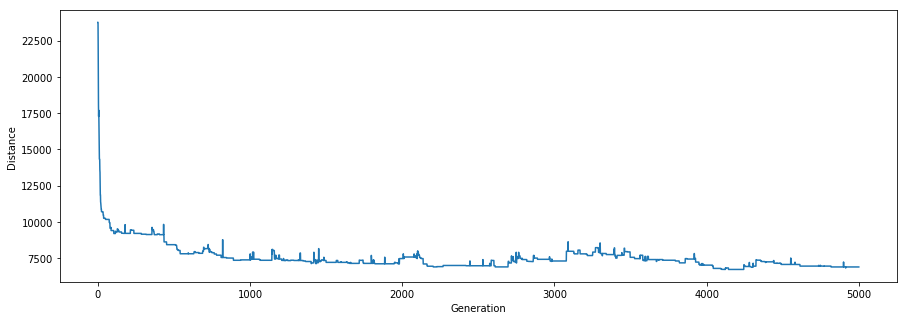

With an error to minimal value of: 0.85%


In [10]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True,
                           verbose=True)

errp = errPerc(bestKnown_tsp['dj38'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

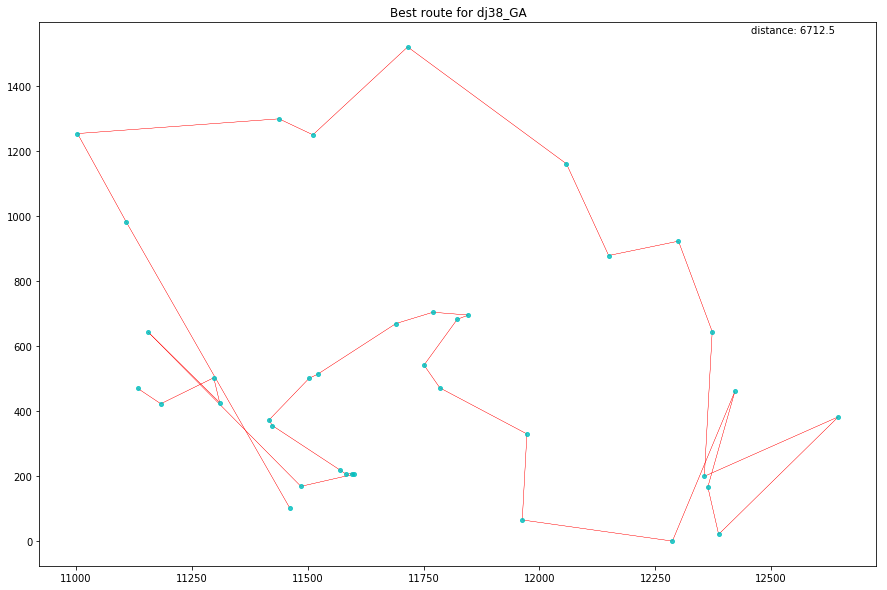

In [11]:
rcParams['figure.figsize'] = 15,10
plot(df_dj38, route, dist, 'dj38_GA', save = True)

### berlin52

In [12]:
cities = []
cities = list(range(len(df_berlin52)))
d_matrix = dist_matrix(df_berlin52)

Initial distance: 26605.436023816783
Final distance: 7880.283822943348
Algorithm completed in 36.35177707672119 s


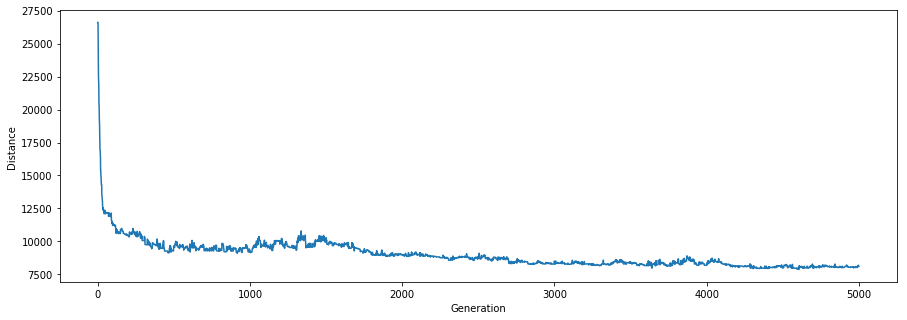

With an error to minimal value of: 4.49%


In [13]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True,
                           verbose=True)

errp = errPerc(bestKnown_tsp['berlin52'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

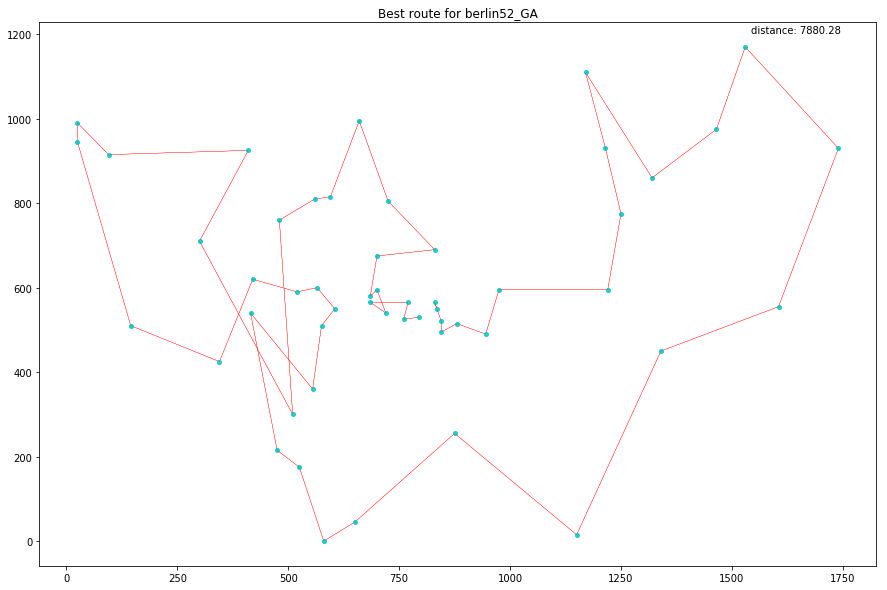

In [14]:
rcParams['figure.figsize'] = 15,10
plot(df_berlin52, route, dist, 'berlin52_GA', save = True)

### ch130

In [15]:
cities = []
cities = list(range(len(df_ch130)))
d_matrix = dist_matrix(df_ch130)

Initial distance: 42803.77680219341
Final distance: 13849.370528476964
Algorithm completed in 70.4915201663971 s


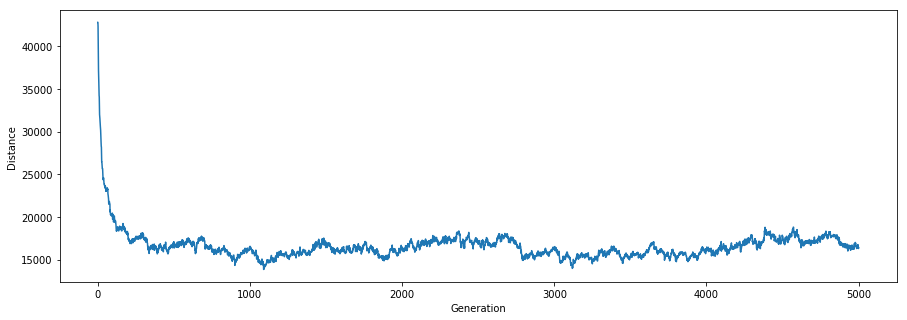

With an error to minimal value of: 126.67%


In [16]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True,
                           verbose=True)

errp = errPerc(bestKnown_tsp['ch130'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

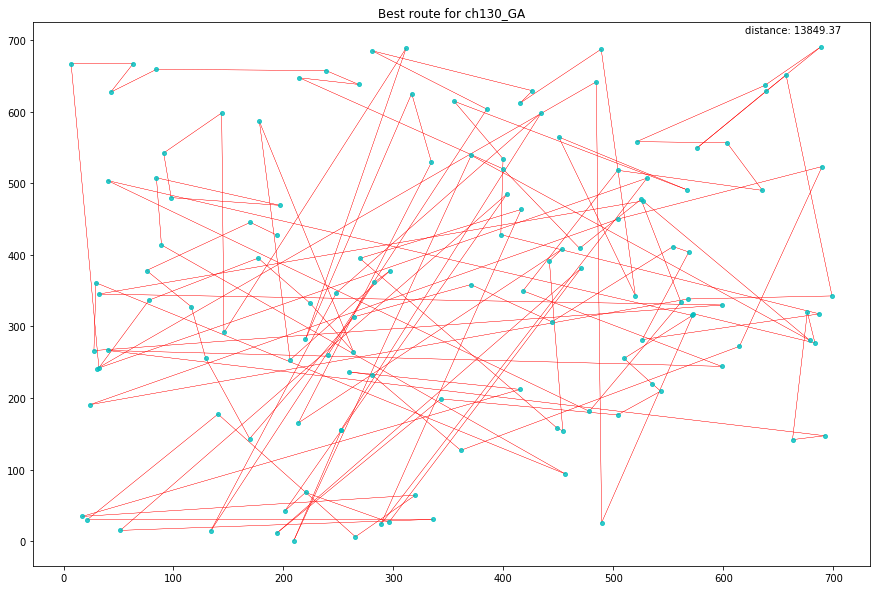

In [17]:
rcParams['figure.figsize'] = 15,10
plot(df_ch130, route, dist, 'ch130_GA', save = True)

### d198

In [18]:
cities = []
cities = list(range(len(df_d198)))
d_matrix = dist_matrix(df_d198)

Initial distance: 174994.2770321033
Final distance: 41639.66831610069
Algorithm completed in 107.16046643257141 s


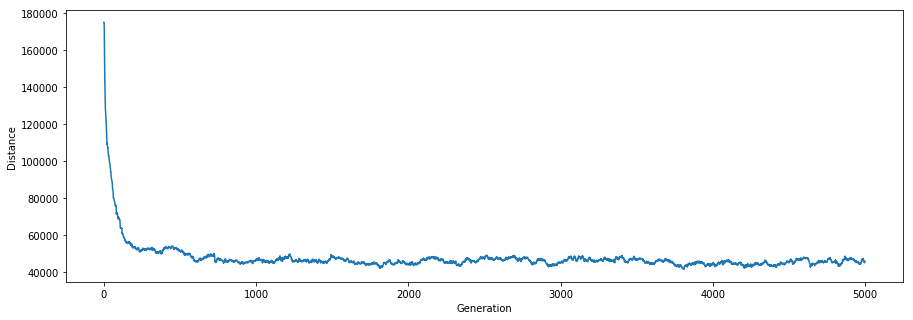

With an error to minimal value of: 163.88%


In [19]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True,
                           verbose=True)

errp = errPerc(bestKnown_tsp['d198'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

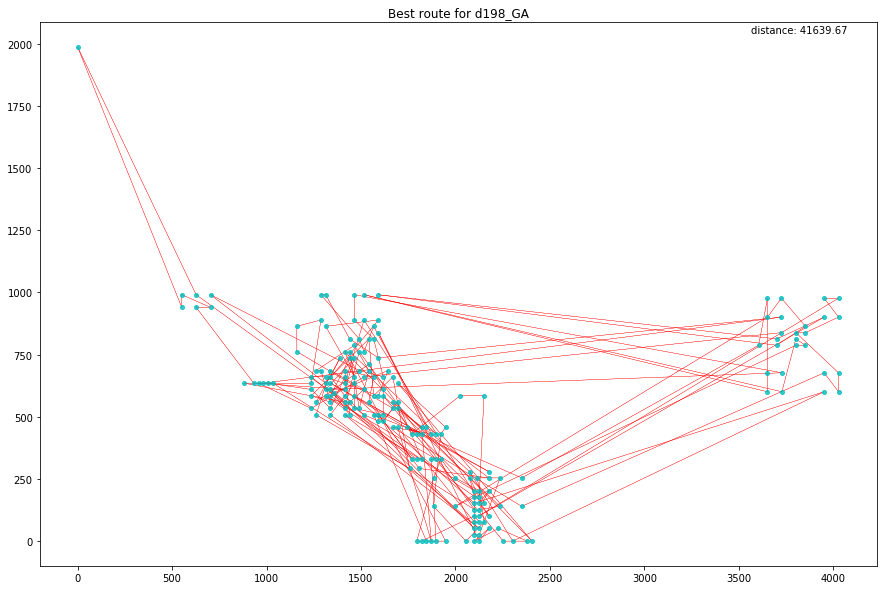

In [20]:
rcParams['figure.figsize'] = 15,10
plot(df_d198, route, dist, 'd198_GA', save = True)

### pr1002

In [21]:
cities = []
cities = list(range(len(df_pr1002)))
d_matrix = dist_matrix(df_pr1002)

Initial distance: 6243687.192305012
Final distance: 2237391.215108798
Algorithm completed in 250.90429306030273 s


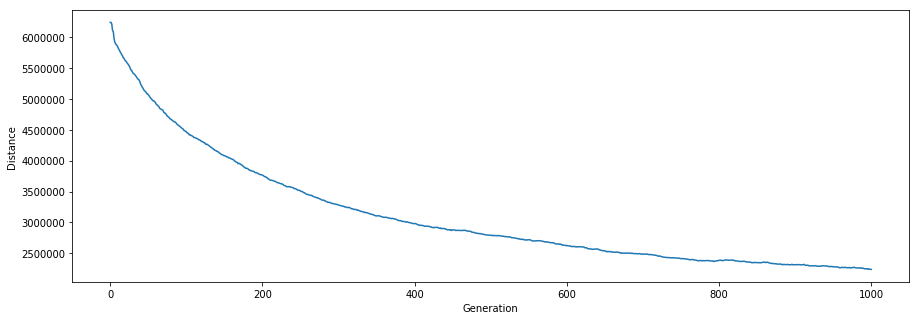

With an error to minimal value of: 763.71%


In [22]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 30,
                         mutation_r = 0.001,
                         n_of_gen = 1000,
                           plot = True,
                           verbose=True)

errp = errPerc(bestKnown_tsp['pr1002'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

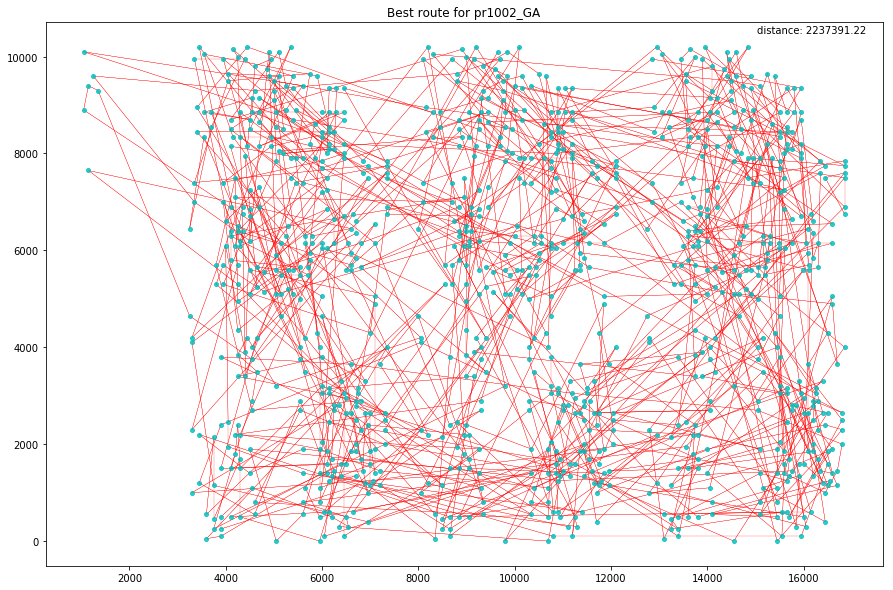

In [23]:
rcParams['figure.figsize'] = 15,10
plot(df_pr1002, route, dist, 'pr1002_GA', save = True)

## Results for GA

In [24]:
ndx = list(bestKnown_tsp.keys())

In [25]:
list_best_dist = list(bestKnown_tsp.values())
list_tuples = list(zip(list_best_dist,list_dist, list_time, list_errp))
results_GA = pd.DataFrame(list_tuples, columns = ['bestDistance', 'distance_GA', 'time_GA', 'error%_GA'],
                          index = ndx)
results_GA

,bestDistance,distance_GA,time_GA,error%_GA
dj38,6656,6.712495e+03,31.826163,0.85
berlin52,7542,7.880284e+03,36.351777,4.49
ch130,6110,1.384937e+04,70.491520,126.67
d198,15780,4.163967e+04,107.160466,163.88
pr1002,259045,2.237391e+06,250.904293,763.71


## K-means with GA (KGA)

First of all we define a function that create a list of clusters

In [26]:
def list_of_clusters(kMeans_results):
    list_of_clusters = []
    for i in range(0, len(np.unique(kMeans_results))):
        tmp = np.where(kMeans_results == i)[0].tolist()
        list_of_clusters.append(tmp)
               
    return list_of_clusters

With KGA we use GA inside every cluster we created

In [27]:
def KGA(list_of_clusters, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot):
    listClusterRoute = []
    for elem in list_of_clusters:
        tmpBestRoute = GenA(permutation = elem, dm = dm,
                         popSize = popSize,
                         selection = selection,
                         elite_n = elite_n,
                         mutation_r = mutation_r,
                         n_of_gen = n_of_gen,
                           plot = plot)[0]
        
        # plot(df_dj38, tmpBestRoute, 'dj38Partial')
        listClusterRoute.append(tmpBestRoute)
    return listClusterRoute

With join_cluster we re-construct the entire list of cities from the previous cluster

In [28]:
def join_cluster(clu1, clu2, d_matrix):
    value = None
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            tmp = d_matrix[clu1[i],clu2[j]]
            if value is None:
                value=tmp
                i_min= i
                j_min = j
            if tmp < value:
                value = tmp
                i_min= i
                j_min = j

    i_min1 = i_min - 1

    j_min1 = j_min -1

    if i_min != len(clu1)-1:
        i_plu1 = i_min + 1
    else:
        i_plu1 = 0

    if j_min != len(clu2)-1:
        j_plu1 = j_min + 1
    else:
        j_plu1 = 0

    #list1 = [clu1[i_min1], clu1[i_plu1]]
    #list2 = [clu2[j_min1], clu2[j_plu1]]

    del tmp
    carlo = np.array([i_min1, i_plu1, j_min1, j_plu1]).reshape(2,2)
    # carlo
    d_ij = d_matrix[clu1[i_min], clu2[j_min]]
    #print(carlo)
    best_norm=None
    best_ip = 0
    best_jp = 0
    for i in carlo[0]:
        d_iip = d_matrix[clu1[i_min], clu1[i]]
        d_ipj = d_matrix[clu2[j_min], clu1[i]]
        for j in carlo[1]:
            
            d_jjp = d_matrix[clu2[j_min], clu2[j]]
            d_ijp = d_matrix[clu1[i_min], clu2[j]]
            d_ipjp = d_matrix[clu1[i], clu2[j]]
            tmp  = d_ij + d_ipjp-d_iip-d_jjp
            tmp1 = d_ijp + d_ipj -d_iip-d_jjp
            n_tmp= math.pow(math.pow(tmp,2)+math.pow(tmp1,2), 1/2 )

            if best_norm is None:
                #print(tmp, tmp1, n_tmp)
                best_norm=n_tmp
                best_jp=j
                best_ip=i

            elif n_tmp < best_norm:
                best_norm=n_tmp
                best_jp=j
                best_ip=i

    #print(carlo,best_ip, best_jp)

    new_seq_i=clu1[best_ip:]+clu1[:best_ip]
    new_seq_j=clu2[best_jp:]+clu2[:best_jp]


    tot_seq_ipjpbestcarlos=new_seq_i+new_seq_j
    return tot_seq_ipjpbestcarlos

# Benchmark KGA

Init our lists for taking trace of solutions compared with optimal

In [29]:
list_dist = []
list_time = []
list_route = []
list_errp = []

### dj38

In [30]:
clustering = KMeans(n_clusters = 2, n_init = 100).fit(df_dj38)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_dj38)
1/routeFitness(centroids, d_matrixCentroid)

1600.8410106144506

In [31]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [32]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [33]:
start = time.time()
Clusterdj38 = KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=1000,
                  plot = False)
end = time.time()
time_ex = end-start

In [34]:
clu_start = Clusterdj38[0]
for i in range(1,len(Clusterdj38)):
    clu_start = join_cluster(clu_start,Clusterdj38[i], d_matrix)
    
dist = 1/routeFitness(clu_start, d_matrix)

errp = errPerc(bestKnown_tsp['dj38'], dist, 2)
print(dist)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(clu_start)
list_errp.append(errp)

11415.338155452731
With an error to minimal value of: 71.5%


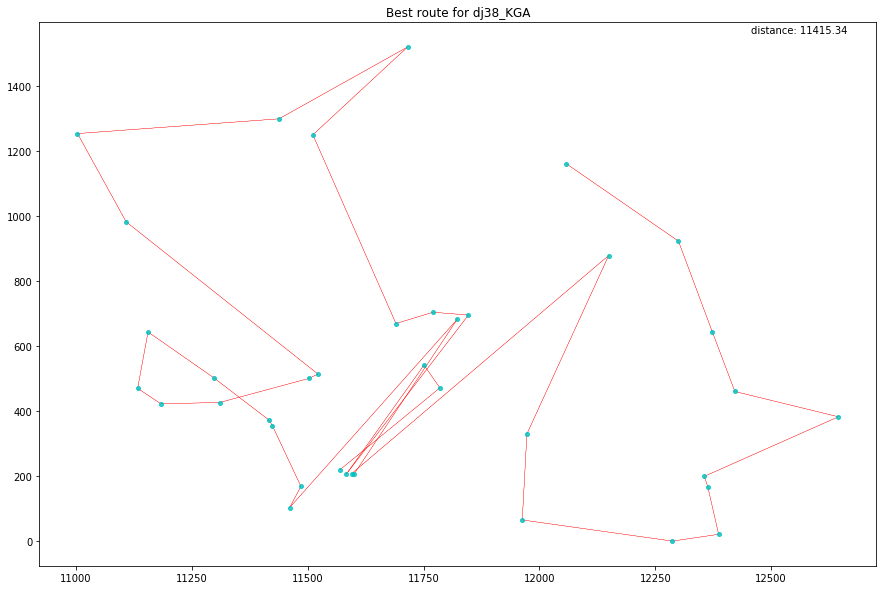

In [35]:
rcParams['figure.figsize'] = 15,10
plot(df_dj38, clu_start, dist, 'dj38_KGA', save = True)

### berlin52

In [36]:
clustering = KMeans(n_clusters = 3, n_init = 100).fit(df_berlin52)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_berlin52)
1/routeFitness(centroids, d_matrixCentroid)

2263.7240240443016

In [37]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [38]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [39]:
start = time.time()
Clusterberlin52 = KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=1000,
                  plot = False)
end = time.time()
time_ex = end-start

In [40]:
clu_start = Clusterberlin52[0]
for i in range(1,len(Clusterberlin52)):
    clu_start = join_cluster(clu_start,Clusterberlin52[i], d_matrix)
    
dist = 1/routeFitness(clu_start, d_matrix)

errp = errPerc(bestKnown_tsp['berlin52'], dist, 2)
print(dist)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(clu_start)
list_errp.append(errp)

8850.13471242269
With an error to minimal value of: 17.34%


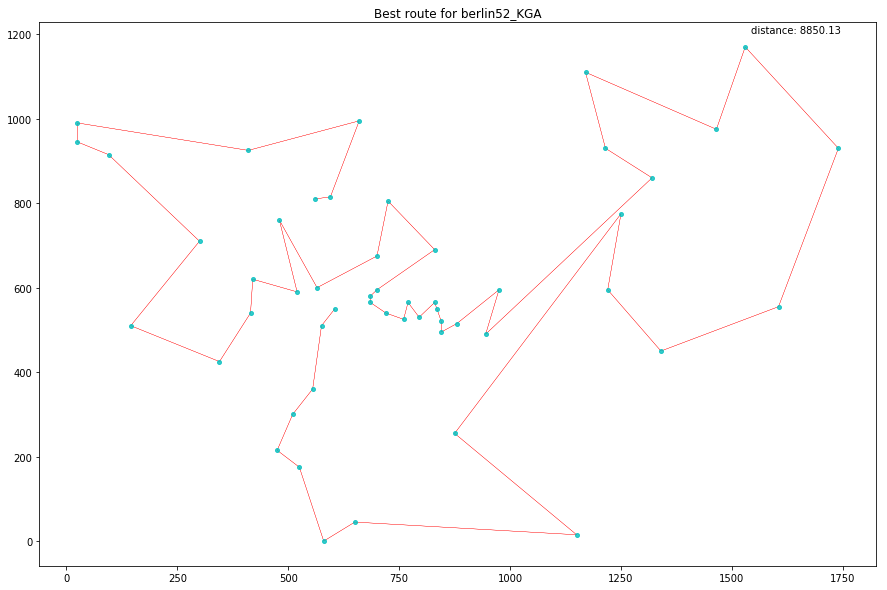

In [41]:
rcParams['figure.figsize'] = 15,10
plot(df_berlin52, clu_start, dist, 'berlin52_KGA', save = True)

### ch 130

In [42]:
clustering = KMeans(n_clusters = 10, n_init = 100).fit(df_ch130)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_ch130)
1/routeFitness(centroids, d_matrixCentroid)

4085.4419583107665

In [43]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [44]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [45]:
start = time.time()
Clusterch130 = KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = False)
end = time.time()
time_ex = end-start

In [46]:
clu_start = Clusterch130[0]
for i in range(1,len(Clusterch130)):
    clu_start = join_cluster(clu_start,Clusterch130[i], d_matrix)
    
dist = 1/routeFitness(clu_start, d_matrix)

errp = errPerc(bestKnown_tsp['ch130'], dist, 2)
print(dist)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(clu_start)
list_errp.append(errp)

8876.52149112631
With an error to minimal value of: 45.28%


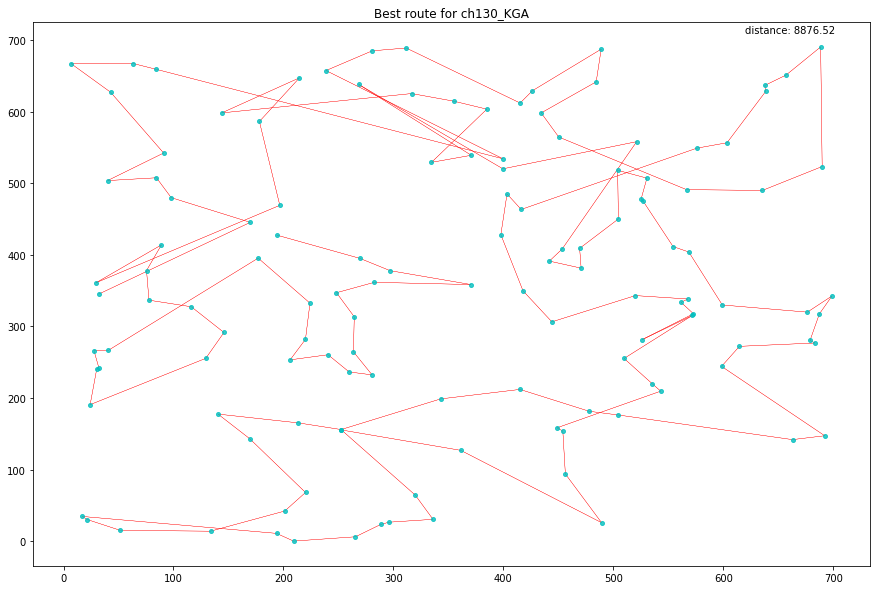

In [47]:
rcParams['figure.figsize'] = 15,10
plot(df_ch130, clu_start, dist, 'ch130_KGA', save = True)

### d198

In [48]:
clustering = KMeans(n_clusters = 30, n_init = 100).fit(df_d198)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_d198)
1/routeFitness(centroids, d_matrixCentroid)

40113.184806175166

In [49]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [50]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [51]:
start = time.time()
Clusterd198 =  KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = False)
end = time.time()
time_ex = end-start

c:\users\massi\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [52]:
clu_start = Clusterd198[0]
for i in range(1,len(Clusterd198)):
    clu_start = join_cluster(clu_start,Clusterd198[i], d_matrix)
    
dist = 1/routeFitness(clu_start, d_matrix)
errp = errPerc(bestKnown_tsp['d198'], dist, 2)
print(dist)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(clu_start)
list_errp.append(errp)

21678.79570265914
With an error to minimal value of: 37.38%


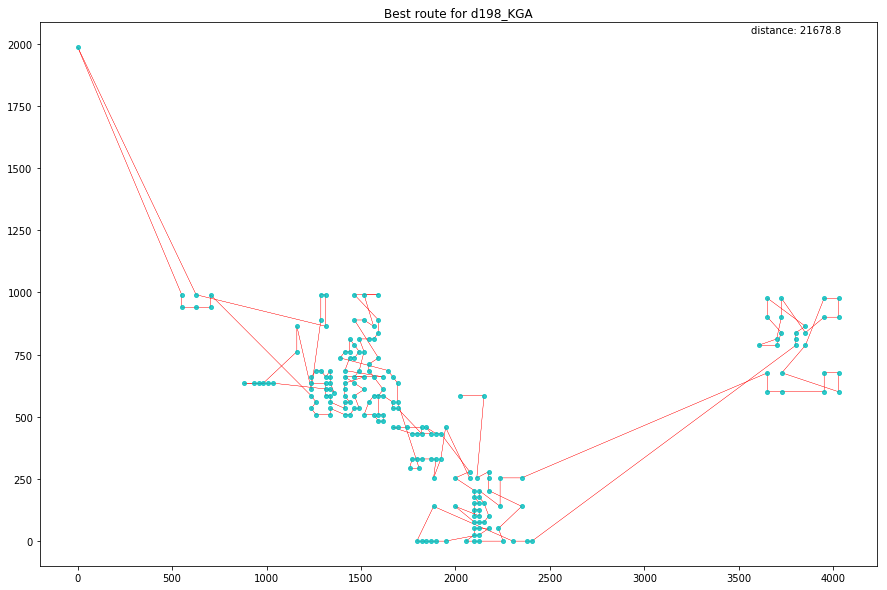

In [53]:
rcParams['figure.figsize'] = 15,10
plot(df_d198, clu_start, dist, 'd198_KGA', save = True)

## pr1002

In [54]:
clustering = KMeans(n_clusters = 100, n_init = 100).fit(df_pr1002)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_pr1002)

In [55]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [56]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [57]:
start = time.time()
Clusterpr1002 =  KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = False)
end = time.time()
time_ex = end-start

c:\users\massi\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [58]:
clu_start = Clusterpr1002[0]
for i in range(1,len(Clusterpr1002)):
    clu_start = join_cluster(clu_start,Clusterpr1002[i], d_matrix)
    
dist = 1/routeFitness(clu_start, d_matrix)
errp = errPerc(bestKnown_tsp['pr1002'], dist, 2)
print(dist)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(clu_start)
list_errp.append(errp)

436857.4932551358
With an error to minimal value of: 68.64%


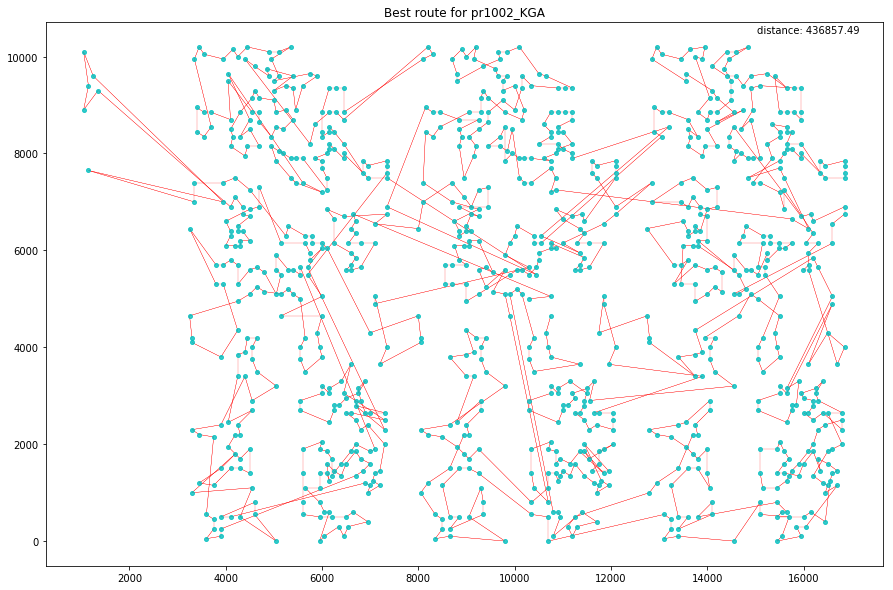

In [59]:
rcParams['figure.figsize'] = 15,10
plot(df_pr1002, clu_start, dist, 'pr1002_KGA', save = True)

## Results for KGA

In [60]:
ndx = list(bestKnown_tsp.keys())

In [61]:
list_best_dist = list(bestKnown_tsp.values())
list_tuples = list(zip(list_best_dist,list_dist, list_time, list_errp))
results_KGA = pd.DataFrame(list_tuples, columns = ['bestDistance', 'distance_KGA', 'time_KGA', 'error%_KGA'],
                           index = ndx)
results_KGA

,bestDistance,distance_KGA,time_KGA,error%_KGA
dj38,6656,11415.338155,38.134038,71.50
berlin52,7542,8850.134712,59.781168,17.34
ch130,6110,8876.521491,19.924729,45.28
d198,15780,21678.795703,58.344012,37.38
pr1002,259045,436857.493255,197.777476,68.64


# Final Results

In [62]:
pd.options.display.float_format = '{:.2f}'.format 
pd.merge(results_GA, results_KGA, left_index=True, right_index=True, on='bestDistance')

,bestDistance,distance_GA,time_GA,error%_GA,distance_KGA,time_KGA,error%_KGA
dj38,6656,6712.50,31.83,0.85,11415.34,38.13,71.50
berlin52,7542,7880.28,36.35,4.49,8850.13,59.78,17.34
ch130,6110,13849.37,70.49,126.67,8876.52,19.92,45.28
d198,15780,41639.67,107.16,163.88,21678.80,58.34,37.38
pr1002,259045,2237391.22,250.90,763.71,436857.49,197.78,68.64
